## Spain Energy Analysis 
To make the successful transition to renewable energy, forecasting is commonly used in the energy markets to understand energy demand as well as energy generation under certain weather or seasonal trend. The use of machine learning on time series datasets is highly leveraged to understand these dynamics. 

This analysis aims to practice data preprocessing, implement algorithms on time-series datasets, and evaluate models using different metrics. This notebook prepares the dataset for further analysis. It presents the process of exploring the energy dataset and interpolates possible missing values. 

In [1]:
# data analysis, wrangling and preprocessing
import numpy as np 
import pandas as pd
import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') # change the style of the plot

# missing data interpolation
from scipy.interpolate import CubicSpline

### Loading data 
We start by loading the dataset into Pandas DataFrames.

In [2]:
energy = pd.read_csv('energy_dataset.csv')
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


Using the `info` function to check if there are any missing values in this dataset and the data type for each column.

In [3]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

Some takeaways from the output above:
* There are two columns (`generation hydro pumped storage aggregated', 'forecast wind offshore day ahead'`) that don't have any values in them. We will drop these two columns. We will also drop the columns that are not useful to our analysis (`total load forecast`, `forecast solar day ahead`, `forecast wind onshore day ahead`, `price day ahead`).
* There might be some missing values for some of the columns. We will try to check the missing rate and decide how to deal with them.
* We will rename the column names because the names of the columns are long and not necessary.

Drop columns that are uninformative for the analysis

In [4]:
dropList = ['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead',
'total load forecast','forecast solar day ahead','forecast wind onshore day ahead',
'price day ahead']
energy.drop(dropList, axis=1, inplace=True)

Find the missing rate for each column

In [5]:
energy.isnull().mean()

time                                           0.000000
generation biomass                             0.000542
generation fossil brown coal/lignite           0.000513
generation fossil coal-derived gas             0.000513
generation fossil gas                          0.000513
generation fossil hard coal                    0.000513
generation fossil oil                          0.000542
generation fossil oil shale                    0.000513
generation fossil peat                         0.000513
generation geothermal                          0.000513
generation hydro pumped storage consumption    0.000542
generation hydro run-of-river and poundage     0.000542
generation hydro water reservoir               0.000513
generation marine                              0.000542
generation nuclear                             0.000485
generation other                               0.000513
generation other renewable                     0.000513
generation solar                               0

All of the columns that have missing data have a missing rate of less than 1%. We will conduct a missingness analysis to see if those missing values are coming from a specific period of time. 

#### Rename columns
We drop the unnecessary text in the column names and rename `total load actual` to `energy demand`.

In [6]:
energy.rename(columns=lambda x: x[11:] if 'generation' in x else x, inplace=True)
energy.rename(columns={'total load actual':'energy demand'}, inplace=True)

#### Create different time granularity
To explore the dataset further, we create a `Year-Month` column for later aggregation purposes.

In [7]:
energy['time'] = pd.to_datetime(energy['time'], utc=True)
energy['Year-Month'] = pd.to_datetime(energy['time'].dt.strftime('%Y-%m-01')).dt.date

### Missingness analysis
Even though the missing rate is less than 1% of the time, we still want to see if they all come from a specific period.

In [8]:
energy[energy.isna().any(axis=1)]

,time,biomass,fossil brown coal/lignite,fossil coal-derived gas,fossil gas,fossil hard coal,fossil oil,fossil oil shale,fossil peat,geothermal,...,nuclear,other,other renewable,solar,waste,wind offshore,wind onshore,energy demand,price actual,Year-Month
99,2015-01-05 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21182.0,59.68,2015-01-01
108,2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.14,2015-01-01
109,2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.95,2015-01-01
110,2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.93,2015-01-01
111,2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.50,2015-01-01
112,2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.85,2015-01-01
113,2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.53,2015-01-01
451,2015-01-19 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39304.0,88.95,2015-01-01
452,2015-01-19 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39262.0,87.94,2015-01-01
643,2015-01-27 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38335.0,83.97,2015-01-01


There are only 47 records that contain NaN in the row. We want to plot these 47 records on a timeline and see if there are any clusters.

Text(0.5, 1.0, 'NaN values across time')

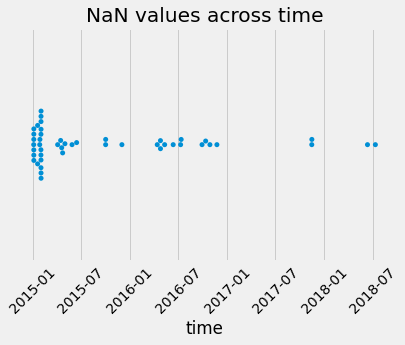

In [9]:
sns.swarmplot(x='time', data=energy[energy.isna().any(axis=1)])
plt.xticks(rotation=45)
plt.title('NaN values across time')

In [10]:
energy[energy.isna().any(axis=1)].groupby('Year-Month')['time'].count()

Year-Month
2015-01-01    11
2015-02-01    11
2015-04-01     4
2015-05-01     2
2015-06-01     1
2015-10-01     2
2015-12-01     1
2016-04-01     3
2016-05-01     1
2016-06-01     1
2016-07-01     2
2016-09-01     1
2016-10-01     2
2016-11-01     1
2017-11-01     2
2018-06-01     1
2018-07-01     1
Name: time, dtype: int64

As we can see in the timeline of the events and frenquency of NaN values by month table above, they scattered around since the data are being recorded. There are several clusters early on, such as the one around January 2015 and May 2015. There are fewer and fewer records recently. It is possible that the instruments were being set up to measure those energy generation data early on, They have a more healthy infrastructure in place to collect necessary data.

### Consolidate different energy sources
We want to consolidate the existing columns into the following columns by summing up the related subcolumns for further analysis. Here is a brief description of each columns:
* Fossil fuel as `fossil_fuel` (nonrenewable energy formed in the geological past from the remains of living organisms)
* Energy generated from biomass as `biomass` (renewable energy produced by living or once-living organisms)
* Energy generated from hydropower as `hydro` (renewable energy generated by fast-running water)
* Energy generated from nuclear energy as `nuclear` (nonrenewable energy that use a nuclear reaction to produce electricity)
* Energy generated from wind energy as `wind` (renewable energy that converts kinetic energy in the wind into mechanical power)
* Energy generated from waste as `waste` (Waste-to-energy plants make steam and electricity)
* Energy generated from other sources as `others`

In [11]:
fossil_fuel = ['fossil brown coal/lignite', 'fossil gas',
       'fossil hard coal', 'fossil oil']
hydro = ['hydro pumped storage consumption',
       'hydro run-of-river and poundage',
       'hydro water reservoir']
wind = ['wind onshore']
others = ['other', 'other renewable'] 
energy['fossil_fuel'] = energy.loc[:, fossil_fuel].sum(axis=1)
energy['hydro'] = energy.loc[:, hydro].sum(axis=1)
energy['wind'] = energy.loc[:, wind].sum(axis=1)
energy['others'] = energy.loc[:, others].sum(axis=1)

We have aggregated there columns:
* `biomass`
* `fossil_fuel`
* `hydro`
* `wind`
* `solar`
* `nuclear`
* `waste`
* `others`

All of them are in Megawatts(MW).

#### Find pattern for zero value entry  
We want to see if any zero values in this dataset are meaningful. If not, they can be treated as missing values (NaN) and interpolate together with other NaN values. 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '2015-01-01'),
  Text(1, 0, '2015-04-01'),
  Text(2, 0, '2015-06-01'),
  Text(3, 0, '2015-10-01'),
  Text(4, 0, '2015-12-01'),
  Text(5, 0, '2016-07-01'),
  Text(6, 0, '2017-11-01'),
  Text(7, 0, '2018-05-01'),
  Text(8, 0, '2018-07-01')])

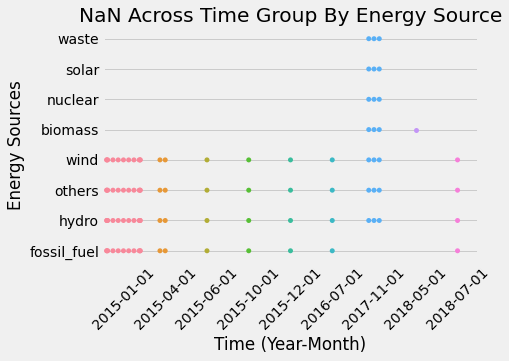

In [12]:
energy_list = ['biomass','fossil_fuel','hydro','wind','solar','nuclear','waste','others']
energy_flat = pd.melt(energy, id_vars='Year-Month', value_vars=energy_list)
tmp = energy_flat.loc[energy_flat.value == 0]
tmp.sort_values(by='Year-Month', inplace=True)
sns.swarmplot(x='Year-Month', y='variable', data=tmp)
plt.title('NaN Across Time Group By Energy Source')
plt.ylabel('Energy Sources')
plt.xlabel('Time (Year-Month)')
plt.xticks(rotation=45)

According to the plot above, we can see that zero values coincide between different energy sources. Since they are sparse earlier in time, we can view them as missing values. As a result, we can replace all the zero values with NaN and interpolate them with all the other NaN values. 

In [13]:
energy[energy_list] = energy[energy_list].replace(['0', 0], np.nan)

### Interpolation
We use two different methods to interpolate all the NaN values that we in the `energy` dataset. 
* If there are multiple NaN values in the close span, we use quadratic interpolation with the order of four to account for the movement of the curve. 
* If there is only one NaN value in the close span, we use the CubicSpline method to interpolate that specific NaN value.

We wrote a function below to automate this process.

In [14]:
def interpolation(column_list, energy):
    for column in column_list:
        index_list = energy[energy[column].isna()].index
        for index in index_list:
            lb = index - 10
            up = index + 10
            if ((energy.iloc[lb:up][column].isna()).sum() > 1):
                temp = energy.iloc[lb:up][column]
                indices = temp[temp.isna()].index
                temp = temp.interpolate(method='quadratic', order=4)
                for index in indices:
                    energy.loc[index, column] = temp.loc[index]
            else:
                lb = index - 2
                up = index + 2
                temp = energy.iloc[lb: up][column]
                temp = temp[~temp.isna()]
                X = temp.index.values
                y = temp.values
                cs = CubicSpline(X , y)
                energy.loc[index, column] = cs(index).item(0)

Call the function `interpolation` and pass in a list of columns that we want to interpolate and the `energy` dataframe.

In [15]:
interpolation(energy_list, energy)

We want to make sure there are no NaN or zero values in the `energy` dataframe before going into further analysis.

In [16]:
energy.loc[:,energy_list].isna().sum() + energy.loc[:,energy_list][energy.loc[:,energy_list] == 0].sum()

biomass        0.0
fossil_fuel    0.0
hydro          0.0
wind           0.0
solar          0.0
nuclear        0.0
waste          0.0
others         0.0
dtype: float64

There is no row with either zero values or NA values after interpolation.

In the next notebook, we will explore the time series of the major sources of energy generation and the relationships between some of the time series.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0623ba08-1bf2-4899-8295-01976760b872' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>